# 🚀 Module 3: Testing Model Endpoint-API

In [ ]:
# Install requirements
!pip install -r requirements.txt

## 📦 Import Required Libraries

Before we proceed with training and tracking our machine learning model, we need to import the necessary libraries.


In [ ]:
# Import necessary modules
import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## ✅ Set Necessary Variables

In [ ]:
# Name of the model API Service or Route
# Similar to SERVICE_NAME.PROJECT_NAME.svc.cluster.local 
# TODO: YOU SHOULD SET THE INFERENCE ENDPOINT (Service endpoint) VARIABLES HERE
MODEL_API_SERVICE = # Inference Endpoint

## 🧪 Test the API Endpoint

### Sending a single Test Inference Request via 'curl' or python module 'requests'

This command sends a test HTTP POST request to the deployed model’s prediction endpoint with a single sample input in JSON format, allowing you to verify that the model is correctly receiving and processing inference requests within the OpenShift cluster.

In [ ]:
!curl -v -X POST http://bike-model-api-svc.bike-model.svc.cluster.local:80/predict \
  -H 'Content-Type: application/json' \
  -d '{"temp": 0.32, "atemp": 0.3485, "humidity": 1.0, "windspeed": 0.0, "hour": 1, "weekday": 5, "season": 1, "holiday": 0, "workingday": 1, "weathersit": 2}'

{"prediction":8.54}

In [ ]:
import requests, os

url = f"http://{MODEL_API_SERVICE}:80/predict"
r = requests.post(url, json={"temp": 0.32, "atemp": 0.3485, "humidity": 1.0, "windspeed": 0.0, "hour": 1, "weekday": 5, "season": 1, "holiday": 0, "workingday": 1, "weathersit": 2})
print("Response Status Code:", r.status_code, r.text)

### Preparing Test Data

We set here the path to a very small portion of the dataset as test data to validate the trained model.

In [ ]:
# Load the saved data to see if it was generated and stored properly.

test_model_path = './data/test_model'

sample_input_loaded = pd.read_csv(f'{test_model_path}/sample_input_data.csv')
# sample_input_loaded.head()
sample_y_input = sample_input_loaded["count"]
print(sample_y_input)

### Batch Inference: Sending Multiple Requests to the Model Endpoint

This section reads multiple JSON-formatted input samples from a file and sends them one-by-one to the model's prediction endpoint. It collects the predicted results and displays them alongside the actual target values in a combined output DataFrame.

In [ ]:
# ── Endpoint ─────────────────────────────────────────────────────────────
endpoint = f"http://{MODEL_API_SERVICE}:80/predict"

# ── Read the JSON-line file and send requests ────────────────────────────
predictions = []

with open(f"{test_model_path}json_input_list.txt") as fh:
    for line_no, line in enumerate(fh, 1):
        line = line.strip()
        
        inference_request = json.loads(line)
        response = requests.post(endpoint, json=inference_request)

        if response.status_code == 200:
            # FastAPI returns {"prediction": <value>}
            predictions.append(response.json()["prediction"])

        else:
            print(f"Request failed with status code: {response.status_code}")
            print(f"Response content: {response.text}")

# ── Assemble results into a DataFrame ────────────────────────────────────
pred_df = pd.DataFrame(predictions, columns=["Predicted Count"])

# Combine predictions with actual classes
actual_class_test = sample_y_input.reset_index(drop=True)
model_output = pd.concat([pred_df, actual_class_test], axis=1)

# Rename columns for clarity
model_output.columns = ['Predicted Count', 'Actual  Count']

# Display the final output
print(model_output)

   Predicted Count  Actual  Count
0         8.540000             10
1       118.955488            122
2        88.637184             93
3       137.775238            130
4       209.155000            220


### 📊 Visualizing Actual vs Predicted Counts for Sample Inputs

This cell visualizes the predicted versus actual bike rental counts for each input sample using a scatter plot. Squares represent the actual values, while crosses indicate the model’s predictions, making it easy to spot discrepancies. This side-by-side comparison helps evaluate how closely the model aligns with real-world outcomes for the selected test samples.

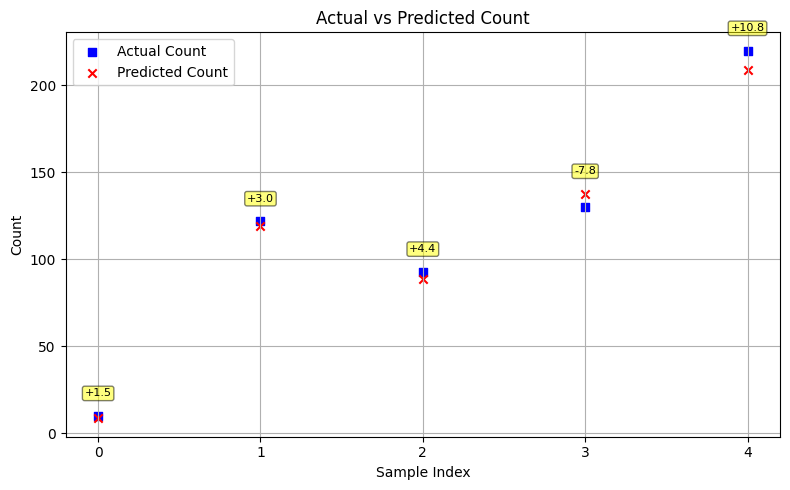

In [ ]:
# Number of samples
x = np.arange(len(model_output))

plt.figure(figsize=(8, 5))

# Plot actual values as squares
plt.scatter(x, model_output['Actual  Count'], label='Actual Count', marker='s', color='blue')

# Plot predicted values as crosses
plt.scatter(x, model_output['Predicted Count'], label='Predicted Count', marker='x', color='red')

# Annotate with differences
for i in x:
    actual = model_output['Actual  Count'][i]
    predicted = model_output['Predicted Count'][i]
    diff = actual - predicted
    plt.text(i, max(actual, predicted) + 10, f'{diff:+.1f}', 
             ha='center', va='bottom', fontsize=8, 
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5))
    
plt.xlabel("Sample Index")
plt.ylabel("Count")
plt.title("Actual vs Predicted Count")
plt.xticks(x)  # Show sample indices clearly
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()